ref: https://dacon.io/competitions/official/235743/codeshare

In [1]:
# 제출용

In [2]:
# train, test=my_split(train_test)
# model_list=[LinearRegression(),Lasso(),ElasticNet(),Ridge(), XGBRegressor(),LGBMRegressor()]

# #----------------------------------------------- 하단 코드 동일
# y = train['중식계']
# X = train.drop(['중식계','석식계'], axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
# model= LGBMRegressor()
# for model in model_list:
#     model.fit(X_train, y_train)
#     pred = model.predict(X_val)
#     mae = mean_absolute_error(y_val, pred)
#     print(f" MAE:{mae:.4f} {model.__class__.__name__}") 


# #------------------------------------------------- 공모전 제출용 학습
# test_pred = model.predict(test)        #---------->  submit 제출 답안
# test_pred = np.round(test_pred, 0).astype(int)

# #------------------------------------------------- 제출 전 확인
# print(len(test_pred), test_pred)
# print(sub['중식계'].min(), sub['중식계'].max())
# print(test.index.values.min()   , test.index.values.max())
# sub.head(1)
# #------------------------------------------------- 답안지 작성
# sub['중식계'] = test_pred.reshape(-1,1)
# print(sub.head(2))
# sub.to_csv("v02.csv", index=False)   

## target feature

In [3]:
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# train.profile_report()

In [4]:
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# train_test.profile_report()

In [1]:
# 분석
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# 경고
import warnings
warnings.filterwarnings(action='ignore')

# 날짜 가공
import datetime as dt 
from dateutil.rrule import rrule, YEARLY, MONTHLY, WEEKLY

# 데이터 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='Gothic') # For Windows. PLOT에서 한글 처리 -> 플롯 만드는 창에 넣어야 됨.

plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # - 기호 안 깨지게
plt.rcParams['font.size'] = 15

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

%matplotlib inline 

# plt.figure(figsize=(12,4)) # plot 12:4 비율

import seaborn as sns
sns.set() # seaborn에서 회색 grid 깔아줌
sns.set(rc={'figure.figsize':(18, 5)}) # 결과 plot 크기 키워줌

# re
import re

In [2]:
# 사이킷런
from sklearn.model_selection import train_test_split

# 사이킷런 분류
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC

# 사이킷런 분류 점수
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# 						 # ---> y_true, y_pred
# from sklearn.metrics import precision_recall_curve # y_true, probas_pred
# from sklearn.metrics import roc_auc_score, roc_curve # y_true, y_score

# 분류 ensemble
# import xgboost as xgb
# from xgboost import plot_importance 
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier # lgb.쓰기 귀찮으니까 Classifier까지 import
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
# 사이킷런 회귀
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV

from sklearn.svm import SVC #linear SVC는 classifier 성 / SVC는 분류말고 회귀에도 쓸 수 있다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 사이킷런 회귀 점수
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score # squared=False로 하면 RMSE

In [4]:
# 사이킷런 스케일러
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# 사이킷런 학습 데이터 증강
# Stratifietrain_testold는 회귀에서는 X
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

# DataLoad & pre-setting

## DataLoad

In [5]:
train=pd.read_csv('./dataset/train.csv', parse_dates=['일자']) # date type
test=pd.read_csv('./dataset/test.csv', parse_dates=['일자'])   # date type
sub=pd.read_csv('./dataset/sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 113.1+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     object        
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 4.0+ KB


In [8]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      50 non-null     object
 1   중식계     50 non-null     int64 
 2   석식계     50 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


## function

### scoring

In [9]:
def my_mae(true, pred):
    mae = np.mean(np.abs(true-pred))
    return mae

### train_test: concate

In [10]:
def my_concat(train_df, test_df):
    train_test_df=pd.concat([train_df, test_df], axis=0)
    return train_test_df

### train_test: split

In [11]:
def my_split(train_test_df):
    train_df=train_test_df[~train_test_df['중식계'].isna()] # iloc으로 자르지 않은 이유는 행을 삭제할 수도 있기 때문
    test_df=train_test_df[train_test_df['중식계'].isna()]
    test_df=test_df.drop(['중식계', '석식계'], axis=1)
    return train_df, test_df

### fit & score & submit

In [12]:
# def my_train_val_split(X, y, cutoff_day=15):
#     X_train=X[X.index.day <= cutoff_day]
#     X_val=X[X.index.day > cutoff_day]
#     y_train=y[y.index.day <= cutoff_day]
#     y_val=y[y.index.day > cutoff_day]
    
    
#     return X_train, X_val, y_train, y_val

In [13]:
# def my_fit_score(train_test, target, model=None, submit_name=None, target_log=False):
    
#     train, test = my_split(train_test)

#     # ------------------------------------------- train & validation
#     X=train.drop(target, axis=1)
#     y=train[target]

#     X_train, X_val, y_train, y_val=my_train_val_split(X,y,shuffle=True,random_state=1024)

#     # ---defualt model is RandomForestRegressor()
    
#     if model ==None:
#         model=RandomForestRegressor()

#     model.fit(X_train, y_train)
#     pred=model.predict(X_val)
#     rmsle = mean_squared_log_error(y_val, pred, squared=False)
#     print(f"RMSLE:{rmsle:.4f} {model.__class__.__name__}") # mean_squared_log_error(squred=False)

#     #------------------------------------------ test submit

#     if submit_name != None:
#         test_pred=model.predict(test)
        
#         if target_log==True:
#             test_pred=np.expm1(test_pred)
        
#         # test_pred=np.round(test_pred, 0).astype('int') #---> 결과 int로 주라고 했다.(반올림 후 astype('int'))
#         submit['count']=test_pred.reshape(-1,1)
#         submit.to_csv(f'./dataset/{submit_name}.csv', index=False)
        

### split & fit & scoring

In [14]:
def reg_fit_score(train_test, target, model_list=False):
    
    train, test = my_split(train_test)
    
    # ------------------------------------------- train & validation
    X=train.drop(['중식계','석식계'], axis=1)
    y=train[target]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1024)

    if model_list==False:
        model_list=[LinearRegression(),Lasso(),ElasticNet(),Ridge()]
        
    score_list=[]

    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
    f, axs = plt.subplots(1, 4, figsize=(18, 4))

    
    for i, model in enumerate(model_list):
        model.fit(X_train, y_train)
        # print(X.columns)
        # print(model.coef_)
        
        axs[i].set_title(model.__class__.__name__)
        sns.barplot(x=model.coef_, y=X.columns, ax=axs[i])
        
        pred=model.predict(X_val)
        score=my_mae(y_val, pred)
        score_list.append(score)
        
        # print(f"{model.__class__.__name__}:\n\t{score[model.__class__.__name__]} ---> {score:.6f}")
    plt.show()
    return score_list

In [15]:
def tree_fit_score(train_test, target, model_list=False):
    
    train, test = my_split(train_test)

    # ------------------------------------------- train & validation
    y=train[target]
    X=train.drop(['중식계','석식계'], axis=1)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1024)
    
    if model_list==False:
        model_list = [XGBRegressor(),LGBMRegressor()]    
    
    score_list=[]
    
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
    f, axs = plt.subplots(1,2, figsize=(16,4))
    
    for i, model in enumerate(model_list):
        model.fit(X_train, y_train)
        #print(model.feature_importances_)
        
        axs[i].set_title(model.__class__.__name__)
        sns.barplot(y=X.columns, x=model.feature_importances_, ax=axs[i])
            
        pred=model.predict(X_val)
        score=my_mae(y_val, pred)
        score_list.append(score)
        
        # print(f"{model.__class__.__name__}:\n\t{score[model.__class__.__name__]} ---> {score:.6f}")
    return score_list

In [16]:
def reg_stacking_fit_score(train_test, target):
    
    train, test = my_split(train_test)

    # ------------------------------------------- train & validation
    y=train[target]
    X=train.drop(['중식계','석식계'], axis=1)
    
    model_list=[LinearRegression(),Lasso(),ElasticNet(),Ridge()]
    score_list=[]
    
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
    f, axs = plt.subplots(1, 4, figsize=(18, 4))
    
    # -------- loop model
    for i, model in enumerate(model_list):
        
        # -------- KFold
        kfold = KFold(n_splits=3, shuffle=True, random_state=1024)
        fold_score_list = []
        fold_coef_array=np.zeros((3, X.shape[1]))
        
        j=0
        
        for train_index, test_index  in kfold.split(X, y) :
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            score=my_mae(y_test, pred)
            fold_score_list.append(score)
            
            fold_coef_array[j,]=model.coef_
            j=j+1
        
        # -------- score
        mean_score=np.array(fold_score_list).mean()
        score_list.append(mean_score)

        # -------- barplot        
        mean_coef_=fold_coef_array.mean(axis=0)
        
        axs[i].set_title(model.__class__.__name__)
        sns.barplot(x=mean_coef_, y=X.columns, ax=axs[i])
    
    return score_list

In [17]:
def tree_stacking_fit_score(train_test, target):
    train, test = my_split(train_test)

    # ------------------------------------------- train & validation
    y=train[target]
    X=train.drop(['중식계','석식계'], axis=1)
    
    model_list = [XGBRegressor(),LGBMRegressor()]    
    score_list=[]
    
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
    f, axs = plt.subplots(1,2, figsize=(16,4))

    
    # -------- loop model
    for i, model in enumerate(model_list):
        
        # -------- KFold
        kfold = KFold(n_splits=3, shuffle=True, random_state=1024)
        fold_score_list = []
        fold_importance_array=np.zeros((3, X.shape[1]))
        
        j=0
        
        for train_index, test_index  in kfold.split(X, y) :
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            score=my_mae(y_test, pred)
            fold_score_list.append(score)
            
            fold_importance_array[j,]=model.feature_importances_
            j=j+1
        
        # -------- score
        mean_score=np.array(fold_score_list).mean()
        score_list.append(mean_score)

        # -------- barplot        
        mean_impo_=fold_importance_array.mean(axis=0)
        
        axs[i].set_title(model.__class__.__name__)
        sns.barplot(x=mean_impo_, y=X.columns, ax=axs[i])
    
    return score_list

In [18]:
# empty score dataframe
index_list=['LinearRegression()','Lasso()','ElasticNet()','Ridge()', 'XGBRegressor()','LGBMRegressor()']
sco_df=pd.DataFrame(index=index_list)

# fit & score & make score dataframe
def fit_score(data, target, trial_name, model_list=False, DF=True):
    
    reg_score_list=reg_fit_score(data, target, model_list)
    tree_score_list=tree_fit_score(data, target, model_list)
    score_list=reg_score_list+tree_score_list
    
    index_list=['LinearRegression()','Lasso()','ElasticNet()','Ridge()', 'XGBRegressor()','LGBMRegressor()']
    score_series=pd.Series(score_list, index=index_list, name=trial_name)
    
    if DF==True:
        global sco_df
        sco_df=pd.concat([sco_df, score_series], axis=1)
        sco_df
    else:
        print(score_series)
    

## train+test

In [19]:
train_test=pd.concat([train, test], axis=0)

In [20]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 49
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   요일              1255 non-null   object        
 2   본사정원수           1255 non-null   int64         
 3   본사휴가자수          1255 non-null   int64         
 4   본사출장자수          1255 non-null   int64         
 5   본사시간외근무명령서승인건수  1255 non-null   int64         
 6   현본사소속재택근무자수     1255 non-null   float64       
 7   조식메뉴            1255 non-null   object        
 8   중식메뉴            1255 non-null   object        
 9   석식메뉴            1255 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 127.5+ KB


# 1차 가공

## 석식계 0인 날

In [21]:
train[train['석식계']==0]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0
224,2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0
244,2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0
262,2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0
281,2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0
306,2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0
327,2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0
346,2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0
366,2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0
392,2017-09-01,금,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0


In [22]:
train[train['석식계']==0]['석식메뉴'].unique()

array(['    *        ', '     *       ', '      자기계발의날      ',
       '      *자기계발의날*      ', '      가정의날      ',
       '쌀밥/잡곡밥 (쌀:국내산) 된장찌개  미니함박조림  계란말이  비름나물  포기김치 (김치:국내산) ',
       '쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국  고추잡채*꽃빵  계란찜  오이무침  포기김치 (김치:국내산) ',
       '      *      ', '            ', '    자기계발의날        ',
       '    자기개발의날        ', '    *  자기계발의날  *    ',
       '    *  자기개발의날  *    ', '   *  자기개발의날  *     ',
       ' ＜자기 계발의 날＞      '], dtype=object)

In [23]:
for uni in train[train['석식계']==0]['석식메뉴'].unique():
    for val in test['석식메뉴']:
        if uni in val:
            print(uni)

In [24]:
test['석식메뉴'].unique()

array(['흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치 ',
       '충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지 ',
       '흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치 ',
       '흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치 ',
       '흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치 ',
       '오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치 ',
       '흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치 ',
       '유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치 ',
       '흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치 ',
       '흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지 ',
       '흑미밥 참치김치찌개 오징어굴소스볶음 차돌비빔국수 건새우무나물 포기김치 ',
       '흑미밥 순두부백탕 수제치킨까스 쫄면채소무침 얼갈이나물 포기김치 ',
       '흑미밥 손수제비국 쇠고기낙지볶음 카레홍합찜 쑥갓나물 포기김치 ',
       '곤드레밥 황태국 찰떡떡갈비조림 계란후라이 재래김*달래양념장 무생채 ',
       '흑미밥 바지락된장찌개 제육볶음 양배추숙*쌈장 노가리고추조림 겉절이김치 ',
       '흑미밥 버섯들깨탕 아귀콩나물찜 콤비네이션피자 돌나물&된장소스 포기김치 ',
       '흑미밥 동태알탕 깐풍육 고사리볶음 오이무침 포기김치 ',
       '흑미밥 쇠고기무국 춘전닭갈비 뉴욕핫도그 유채나물된장무침 포기김치 ',
       '애플카레라이스 팽이장국 가지탕수 소떡소떡 오복지무침 포기김치 ',
       '흑미밥 계란파국 쭈꾸미불고기 모둠채소전*장 씨앗콩자반 포기김치 ',
       '흑미밥 스팸김치찌개 삼치구이*와사비장 브로콜리깨소스무침 연근

## 메뉴 나누기
ref: https://dacon.io/competitions/official/235743/codeshare/2974?page=2&dtype=recent

In [25]:
# Menu-extracting function
def extractMenu(array, keywords=[], not_in_keywords={}, comm_not_in=[]):
    extractedMenu = []
    for menu_nm in array:
        for kw in keywords:
            if menu_nm.find(kw) > -1:
                has_not_in = False
                if kw in not_in_keywords:
                    for sub_kw in not_in_keywords[kw]:
                        if menu_nm.find(sub_kw) > -1:
                            has_not_in = True
                            break
                for sub_kw in comm_not_in:
                    if menu_nm.find(sub_kw) > -1:
                        has_not_in = True
                        break

                if not has_not_in:
                    extractedMenu.append(menu_nm)
                    break
    return(extractedMenu)

def extractMenu2(array, keywords=[]):
    extractedMenu = []
    for menu_nm in tot_menu_arr:
        for kw in keywords:
            if menu_nm.find(kw) > -1:
                menu_nm_list = re.split(r'[^\w]', menu_nm)
                for menu_nm_tmp in menu_nm_list:
                    if menu_nm_tmp.find(kw) + len(kw) == len(menu_nm_tmp): # 끝에 있으면
                        extractedMenu.append(menu_nm)
                break
    return(extractedMenu)

In [26]:
lunch_menu_data = train_test['중식메뉴']
dinner_menu_data = train_test['석식메뉴']

In [27]:
tot_menu_arr = []
pattern = r"\(.*\)"
for menu_data in [lunch_menu_data, dinner_menu_data]:
    for daily_menu in menu_data:
        menu_list = daily_menu.strip().split()
        menu_list2 = []
        for i, menu_nm in enumerate(menu_list):
            menu_nm = re.sub(pattern, '', menu_nm)
            if menu_nm.strip() in ['', '*']:
                continue
            if menu_nm[0] == '(' or menu_nm[-1] == ')':
                continue
            menu_list2.append(menu_nm)
        tot_menu_arr += menu_list2

In [28]:
tot_menu_arr = set(tot_menu_arr)

In [29]:
len(tot_menu_arr)

2825

In [30]:
# 육류 분류
# 소고기
# https://namu.wiki/w/%EC%87%A0%EA%B3%A0%EA%B8%B0
beef = ['소고기', '쇠고기', '불고기', '떡갈비', '갈비찜', '소갈비', '육사시미', '육회', '장조림', '와규', '야키니쿠', '규동', '스테이크', '햄버그 스테이크',
 '함박스테이크', '함바그스테이크', '함박 스테이크', '햄버거', '로스트 디너', '비프가스밀라네사', '웰링턴', '슈하스쿠', '아사도', '우육면',
 '육개장', '육포', '평양냉면', '비프 스트로가노프', '설렁탕', '소고기국', '소머리국밥', '곰탕', '너비아니', '보르챠', '소꼬리']
# 돼지고기
# https://namu.wiki/w/%EB%8F%BC%EC%A7%80%EA%B3%A0%EA%B8%B0
pig = ['돼지', '돼지머리', '머릿고기', '뒷고기', '관자살', '콧등살', '삼각살', '설중살', '설하살', '안중살', '뽈항정살',
 '볼살', '두항정', '돼지코', '항정살', '목살', '가브리살', '갈비', '앞다리살', '갈매기살', '등심', '안심',
 '삼겹살', '오겹살', '뒷다리살', '돈족', '내장', '오소리감투', '허파', '염통', '콩팥', '새끼보', '돈낭',
 '돈족', '돼지꼬리', '사태', '막창', '감자탕', '돈가스', '돼지갈비', '돼지국밥', '돼지불고기', '두루치기', '순대',
 '순댓', '족발', '보쌈', '수육', '편육', '제육', '탕수육', '삼겹', '맥적', '차슈', '향우구육', '꿔바로우', '훙사오러우',
 '회과육', '동파육', '라후테', '오향장육', '슈바인스학세', '소시지', '소세지', '포크 커틀릿', '함바그 스테이크', '함바그스테이크',
 '함박스테이크', '살스테이크','살 스테이크', '함박 스테이크', '베이컨', '햄', '스팸', '폭립', '폭찹', '돈지루', '부타동', '바쿠테', '팟 카파오 무 쌉', '비엔나', '소떡', '육']
# 닭고기
# https://namu.wiki/w/%EB%8B%AD%EA%B3%A0%EA%B8%B0
chicken = ['닭', '깐풍기', '꼬꼬면', '궁보계정', '간장닭', '기스면', '계', '도빙무시', '라조기', '백숙', '영계백숙',
 '불닭', '삼계탕', '삼계선', '오니시메', '옻닭', '연팔기', '유린기', '육회', '좌종당계', '찜닭', '초계밀면',
 '치킨', '도리텐', '지파이', '치짜', '취계', '카라아게', '가라아', '파닭', '양파닭', '케밥', '코코뱅', '탕수기',
 '포계', '프랑구 아사두']
# 양고기
# https://namu.wiki/w/%EC%96%91%EA%B3%A0%EA%B8%B0
sheep = ['양고기','훠궈', '양꼬치', '케밥', '샤슬릭', '징기스칸', '셰퍼드 파이', '허르헉', '양갈비']
# 오리고기
# https://namu.wiki/w/%EC%98%A4%EB%A6%AC%EA%B3%A0%EA%B8%B0
dug = ['오리']

web_keywords = beef + pig + chicken + sheep + dug
keywords = ['돈까스', '히레카츠', '히레까쓰', '히레가스', '포크', '부대찌개', '뒷다리', '앞다리', '돈', '순살',
                '소머리', '등뼈', '곱창', '도가니', '뼈해장국', '뼈다귀해장국', '목심', '채끝', '우둔', '양지', '설도', '만두', '만둣',
                '잡채', '류산슬', '유산슬', '고기', '고깃']
keywords += web_keywords

not_in_keywords = {'오리':['아오리', '오리엔탈'], '계':['계란', '계발', '계피'], '장조림':['계란', '메추리알'], '치킨':['치킨무'], '돈':['돈나물'], '만두':['당면계란'], '만둣':['당면계란']}
meat_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [31]:
# 돼지고기
keywords = ['돼지', '돼지머리', '머릿고기', '뒷고기', '관자살', '콧등살', '삼각살', '설중살', '설하살', '안중살', '뽈항정살',
 '볼살', '두항정', '돼지코', '항정살', '목살', '가브리살', '앞다리살', '갈매기살', '등심', '안심',
 '삼겹살', '오겹살', '앞다리살', '뒷다리살', '돈족', '내장', '오소리감투', '허파', '염통', '콩팥', '새끼보', '돈낭',
 '돈족', '돼지꼬리', '사태', '막창', '감자탕', '돈가스', '돼지갈비', '돼지국밥', '돼지불고기', '두루치기', '순대',
 '순댓', '족발', '보쌈', '수육', '편육', '제육', '탕수육', '삼겹', '맥적', '차슈', '향우구육', '꿔바로우', '훙사오러우',
 '회과육', '동파육', '라후테', '오향장육', '슈바인스학세', '소시지', '소세지', '포크 커틀릿',
 '목살스테이크','목살 스테이크', '베이컨', '햄', '스팸', '폭립', '폭찹', '돈지루', '부타동', '바쿠테', '팟 카파오 무 쌉', '비엔나', '소떡',
 '돈까스', '히레카츠', '히레까쓰', '히레가스', '포크', '돈', '등뼈', '뼈해장국', '뼈다귀해장국']
not_in_keywords = {'돈':['돈나물'], '만두':['당면계란'], '만둣':['당면계란']}
pig_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [32]:
# 소고기
keywords = ['소고기', '쇠고기', '소불고기', '소갈비', '육사시미', '육회', '와규', '야키니쿠', '규동', '소곱창',
            '로스트 디너', '비프가스밀라네사', '웰링턴', '슈하스쿠', '아사도', '우육면',
            '육개장', '육포', '평양냉면', '비프 스트로가노프', '설렁탕', '소고기국', '소머리국밥', '곰탕', '너비아니', '보르챠', '소꼬리', '소머리', '설도', '목심', '채끝', '우둔', '양지', '도가니']
beef_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [33]:
# 닭고기
keywords = ['닭', '깐풍기', '꼬꼬면', '궁보계정', '간장닭', '기스면', '계', '도빙무시', '라조기', '백숙', '영계백숙',
          '불닭', '삼계탕', '삼계선', '오니시메', '옻닭', '연팔기', '유린기', '육회', '좌종당계', '찜닭', '초계밀면',
          '치킨', '도리텐', '지파이', '치짜', '취계', '카라아게', '가라아', '파닭', '양파닭', '케밥', '코코뱅', '탕수기',
          '포계', '프랑구 아사두']
not_in_keywords = {'계':['계란', '계발', '계피'], '치킨':['치킨무']}

chicken_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [34]:
# 양고기 - 데이터 없어서 제외
keywords = ['양고기','훠궈', '양꼬치', '케밥', '샤슬릭', '징기스칸', '셰퍼드 파이', '허르헉', '양갈비']
sheep_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])
sheep_menus

[]

In [35]:
# 오리고기
keywords = ['오리']
not_in_keywords = {'오리':['아오리', '오리엔탈']}
duck_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [36]:
#난류 (계란)
keywords = ['계란', '난', '란', '메추리알', '날치알', '동태알']
not_in_keywords = {"란":['토란'], '난':['커리', '카레']}
egg_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [37]:
# 죽류
keywords = ['죽', '누룽지']
juk_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [38]:
# 덮밥 및 국밥류
keywords = ['덮밥', '국밥']
gukbob_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [39]:
# 비빔밥 및 볶음밥류
keywords = ['비빔밥', '볶음밥']
bb_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [40]:
# 국탕류
keywords = ['국', '탕', '찌개', '국물']
soup_menus = extractMenu2(tot_menu_arr, keywords=keywords)

In [41]:
# 구이류
keywords = ['구이']
gui_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [42]:
# 전류
keywords = ['전', '부침개', '빈대떡']
jeon_menus = extractMenu2(tot_menu_arr, keywords=keywords)

In [43]:
# http://yaksik.net/detail.php?number=24904
# 튀김류
keywords = ['튀김', '까스', '카츠', '가츠', '까츠', '탕수', '덴뿌라', '덴푸라', '크로켓', '고로케', '맛탕', '치킨', '통닭', '부각', '강정', '김말이', '깐풍']
fry_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [44]:
# 곡물
keywords = ['현미', '밥', '쌀', '보리', '죽', '참깨', '들깨', '수수', '잡곡', '귀리', '퀴노아', '아마란스', '옥수수', '기장', '메밀', '모밀']
grain_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [45]:
# 콩류
keywords = ['콩', '녹두', '팥', '완두']
not_in_keywords = {'콩':['콩나물']}
bean_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])


In [46]:
# 묵
keywords = ['묵']
not_in_keywords = {'묵':['어묵', '묵은지']}
kor_jelly_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [47]:
# 생선 및 조개류
# https://ko.wikipedia.org/wiki/%EC%83%9D%EC%84%A0
# https://namu.wiki/w/%EC%83%9D%EC%84%A0
# https://namu.wiki/w/%EC%A1%B0%EA%B0%9C
keywords = ['생선', '조개', '메기', '송어', '오징어', '굴', '멸치', '숭어', '성게', '고등어', '명태',
            '쏨뱅이', '연어', '틸라피아', '우럭', '이리치', '가재', '참바리', '상어', '돔',
            '삼치', '방어', '참치', '새우', '문어', '홍어', '농어', '붉평치', '청상아리', '황새치',
            '다랑어', '비막치어', '장어', '녹새치', '숭어', '굴비', '조기', '갈치', '꽁치',
            '전어', '명태', '노가리', '황태', '은어', '가물치', '쏘가리', '붕어', '잉어', '모래마주', '가자미',
            '간재미', '가오리', '박대', '양미리', '과메기', '청어', '생태',
            '개복치', '광어', '넙치', '기름치', '까나리', '날치','놀래미'
            ,'능성어','달고기','대구','도다리','도루묵','도미','독가시치'
            ,'만새기','망상어','문절망둑','물메기','미꾸라지','민어','방어'
            ,'추어탕','배스','밴댕이','뱅어','벵에돔','병어','보리멸'
            ,'복어','볼락','부세','부시리','붕장어','블루길'
            ,'빙어','산천어','서대','시샤모','쏘가리','쏠배감펭','쏨뱅이'
            ,'아귀','아구','임연수','전갱이','전복치','점성어','정어리'
            ,'준치','쥐치','청새치','청어','향어','홍어','황새치','매운탕'
            ,'루테피스크','게맛살','물회','회덮밥','부야베스','북엇국','세꼬시','수르스트뢰밍','식해','어묵','오뎅'
            ,'쥐포','추어탕','피시 앤드 칩스','피쉬 앤드 칩스','피시앤드칩스','피쉬앤드칩스','피시앤칩스','피쉬앤칩스','해물'
            ,'가리비', '개오지', '꼬막','대칭이','바지락','백합','홍합','소라', '골뱅이', '고둥','재첩'
            ,'전복','플라티케라무스', '봉골레', '클램차우더']
not_in_keywords = {'굴':['굴소스'], '새우':['새우젓']}
fish_shell_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [48]:
# 채소류
# https://namu.wiki/w/%EC%B1%84%EC%86%8C?from=%EC%95%BC%EC%B1%84
keywords = ['가지', '갓', '감자', '고구마', '고사리', '고추', '페페론치노', '냉이', '근대', '깻잎', '차조기'
            , '당근', '더덕', '도라지', '동아', '딸기', '마', '마늘', '멜론', '무', '무청'
            , '바나나', '배추', '버섯', '부추', '브로콜리', '상추', '생강', '쇠비름', '나물'
            , '쑥', '시금치', '수박', '시호', '아스파라거스', '야콘', '양파', '여주', '연근', '열무', '오이'
            , '우엉', '인삼', '죽순', '청경채', '참외', '칡', '풋콩', '토란', '토마토', '쪽파', '대파', '파인애플'
            , '파프리카', '피망', '케일', '고수', '로즈마리', '루타바가', '바질', '박하', '산마늘', '셀러리'
            , '아티초크', '타임', '파슬리', '호박', '피클', '파채', '파김치', '채소', '야채']
not_in_keywords = {'무':['무침'], '마':'마카로니', '고추':['고추장']}
vegetable_menus =  extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [49]:
# 해조류
# https://namu.wiki/w/%EC%A1%B0%EB%A5%98(%EC%88%98%EC%A4%91%EC%83%9D%EB%AC%BC)?from=%ED%95%B4%EC%A1%B0%EB%A5%98
keywords = ['김', '우뭇가사리', '한천', '매생이', '파래', '바다포도', '해캄', '클로렐라', '청각', '마리모모스볼', '다시마', '미역', '감태', '톳']
not_in_keywords = {'김':['김치', '튀김', '김칫']}
sea_alg_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [50]:
# 발효된 콩 상품 -> 장류
# https://namu.wiki/w/%EC%9E%A5%EB%A5%98
keywords = ['된장', '간장', '쯔유', '노추', '미소', '고추장', '청국장', '담북장', '팥장', '두부장', '비지장', '어육장', '춘장', '마장', '낫토', '두반장', '해선장', '굴소스', '게장',
 '장조림', '양념장', '장국', '쌈장', '초장', '*장']
jang_menus  = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [51]:
# 김치
# https://namu.wiki/w/%EA%B9%80%EC%B9%98
keywords = ['김치', '깍두기', '석박지', '동치미', '겉절이', '묵은지', '소박이', '섞박지', '생채', '게국지', '김칫']
kimchi_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [52]:
# 만두
# https://namu.wiki/w/%EB%A7%8C%EB%91%90
keywords = ['만두', '춘권', '만쥬', '사모사', '만둣']
mandu_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords={}, comm_not_in=[])

In [53]:
# 곡물 가루(밀가루, 쌀가루 등 전분)
# https://namu.wiki/w/%EB%B0%80%EA%B0%80%EB%A3%A8
# 미숫가루
keywords = ["면", "수제비", "전", "부침개", "빵", "춘권", "튀김", "과자", "국수", "메밀", "모밀", "피자", "전병", "떡", "어묵", "오뎅", "소시지", "소세지", "햄", "김밥", 
            "부대찌개", "스콘", "만두", "파이", "빈대떡", "케이크", "케익", "쿠키", "핫도그", "파스타", "치킨", "라자냐", "팟타이", "나쵸", "팝콘", '스파게티', '짬뽕']
not_in_keywords = {'치킨':['치킨무'], '전':['전주식'], '짬뽕':['고기', '찌개', '국']}
powder_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=[])

In [54]:
# 과일
# https://namu.wiki/w/%EA%B3%BC%EC%9D%BC
# https://namu.wiki/w/%EC%88%98%EC%9E%85%20%EA%B3%BC%EC%9D%BC
keywords = ['구기자','매실','무화과','버찌','체리','복분자','복숭아','블랙베리','블루베리','딸기','살구','앵두','자두','포도'
            ,'감','다래','대추','머루','모과','무화과','배','사과','석류','으름','귤','유자','레드향','천혜향','한라봉'
            ,'과라나','구아바','구즈베리','토마토','나랑히야','노니','노팔','니파팜','두꾸','두리안','라임','람부탄'
            ,'레몬','애플','루비솔트부쉬','리치','여지','마랑','마룰라','마르멜로','마프랑','망고','블랙베리','아보카도'
            ,'아로니아','아사이베리','아사이 베리','양초열매','오렌지','올리브','용안','롱간','자몽','바나나','딸기','수박'
            ,'참외','멜론','메론','여주','파인애플','토마토','코코넛','크랜베리','타마린드','파파야','패션프루트','패션후르츠']
not_in_keywords = {'살구':['구이', '목살', '삼겹살', '가브리살', '갈비살', '항정살'], '감':['감자'], '배':['배추', '알배기', '소배기']}
comm_not_in = ['주스', '쥬스', '음료', 'D', '순']
fruit_menus = extractMenu(tot_menu_arr, keywords=keywords, not_in_keywords=not_in_keywords, comm_not_in=comm_not_in)

## 메뉴 추가 특성2

In [55]:
# 쌀
# https://namu.wiki/w/%EA%B3%A1%EB%AC%BC

keywords = ['쌀', '잡곡', '오곡', '현미', '흑미', '귀리', '차조', '렌틸콩', '강낭콩', '병아리콩', '완두콩', '기장', '보리', '수수', '호밀'] 
not_in_keywords = {'쌀':['쌀국수', '찹쌀'], '기장':['장조림'], '수수':['옥수수', '부꾸미']} # 찹쌀은 밥 메뉴명에 쓰이지 않아 삭제
comm_not_in = ['스프']
rice_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)


In [56]:
# 김밥 및 초밥

keywords = ['김밥', '초밥'] 
not_in_keywords = {'김밥':['볶음밥']}
comm_not_in = []
gimbab_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [57]:
# 소금, 식초 등에 절인 해산물
# 해산물이 들어있지 않은 절임류도 포함시킴

keywords = ['절임', '젓'] 
not_in_keywords = {}
comm_not_in = []
saused_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [58]:
# 면류
# https://femiwiki.com/w/%EB%B6%84%EB%A5%98:%EC%A2%85%EB%A5%98/%EB%A9%B4%EC%9A%94%EB%A6%AC
keywords = ['국수', '면', '파스타', '스파게티', '짬뽕', '라면'] 
not_in_keywords = {'짬뽕':['고기', '찌개', '국']}
comm_not_in = []
noodle_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [59]:
# 스튜 - 조림과 찌개의 중간단계
# https://namu.wiki/w/%EC%8A%A4%ED%8A%9C
keywords = ['스튜', '조림'] 
not_in_keywords = {}
comm_not_in = []
stew_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [60]:
# 한국 전통 샐러드
keywords = ['나물', '무침'] 
not_in_keywords = {'나물':['콩나물', '밥']}
comm_not_in = []
namul_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [61]:
# 피클
keywords = ['피클'] 
not_in_keywords = {}
comm_not_in = []
pickle_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [62]:
# 샐러드
keywords = ['샐러드'] 
not_in_keywords = {}
comm_not_in = []
salad_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [63]:
# 우유
# 우유가 들어간 식재료(크림, 요거트 등)종류로 변경
keywords = ['까르보나라', '크림', '요거트'] 
not_in_keywords = {}
comm_not_in = ['샐러드', 'D', '드레싱', '소스'] # 샐러드 드레싱, 디핑소스 제외
milk_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [64]:
# 빵, 쿠키
# https://ko.wikipedia.org/wiki/%EB%B9%B5_%EB%AA%A9%EB%A1%9D
keywords = ['와플', '케이크', '케잌', '바게트', '도넛', '도너츠', '핫도그', '도라야키', '베이글', '번', '비스킷', '스콘', '토스트', '브레드', '포카차', '피자', '호두과자', '쿠키'] 
not_in_keywords = {}
comm_not_in = []
bread_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [65]:
# 음료
# https://ko.wikipedia.org/wiki/%EB%B9%B5_%EB%AA%A9%EB%A1%9D
keywords = ['주스', '쥬스', '수정과', '식혜', '식초', '코코아', '칵테일', '스무디', '우유', '셰이크', '야쿠르트', '요구르트', '커피', '차', '탄산수', '음료'] 
not_in_keywords = {'차':['차돌']}
comm_not_in = []
drink_menus = extractMenu(tot_menu_arr, keywords, not_in_keywords, comm_not_in)

In [66]:
def get_food_one_hot(x, menu_array):
    menu_list = x.strip().split()
    for i, menu_nm in enumerate(menu_list):
        menu_nm = re.sub(pattern, '', menu_nm)
        if menu_nm.strip() in ['', '*']:
            continue
        if menu_nm[0] == '(' or menu_nm[-1] == ')':
            continue
        try:
            if menu_array.index(menu_nm) > -1:
                return 1
        except Exception:
            pass
    return 0

In [67]:
# 데이터 병합
menu_col_nm = ['육류', '난류', '죽류', '덮밥_국밥류', '비빔밥_볶음밥류', '국탕류', '구이류', '전류', '튀김류', '곡물', '콩류',
               '묵', '생선_조개류', '채소류', '해조류', '장류', '김치', '만두', '곡물가루', '과일', '쌀', '김밥_초밥', '절임류',
               '면류', '스튜', '나물_무침류', '피클', '샐러드', '우유', '빵류', '음료', '돼지고기', '소고기', '닭고기', '오리고기']
menu_data_arr = [meat_menus, egg_menus, juk_menus, gukbob_menus, bb_menus, soup_menus, gui_menus, jeon_menus, fry_menus, grain_menus, bean_menus,
                 kor_jelly_menus, fish_shell_menus, vegetable_menus, sea_alg_menus, jang_menus, kimchi_menus, mandu_menus, powder_menus, fruit_menus, rice_menus, gimbab_menus, saused_menus,
                 noodle_menus, stew_menus, namul_menus, pickle_menus, salad_menus, milk_menus, bread_menus, drink_menus, pig_menus, beef_menus, chicken_menus, duck_menus]

for col_type in ['중식메뉴', '석식메뉴']:
    for i, menu_arr in enumerate(menu_data_arr):
        train[col_type + '_' + menu_col_nm[i]] = train[col_type].apply(lambda x: get_food_one_hot(x, menu_arr))
        test[col_type + '_' + menu_col_nm[i]] = train[col_type].apply(lambda x: get_food_one_hot(x, menu_arr))

In [68]:
train_test = pd.concat([train, test], axis=0).reset_index(drop=True)
# train_test = train_test.fillna(0)
train_test.columns = ['일자', '요일', '정원', '휴가자', '출장자', '야근자', '재택근무자', '조식', '중식', '석식',\
              '중식계', '석식계', '중식메뉴_육류',
       '중식메뉴_난류', '중식메뉴_죽류', '중식메뉴_덮밥_국밥류', '중식메뉴_비빔밥_볶음밥류', '중식메뉴_국탕류',
       '중식메뉴_구이류', '중식메뉴_전류', '중식메뉴_튀김류', '중식메뉴_곡물', '중식메뉴_콩류', '중식메뉴_묵',
       '중식메뉴_생선_조개류', '중식메뉴_채소류', '중식메뉴_해조류', '중식메뉴_장류', '중식메뉴_김치', '중식메뉴_만두',
       '중식메뉴_곡물가루', '중식메뉴_과일', '중식메뉴_쌀', '중식메뉴_김밥_초밥', '중식메뉴_절임류', '중식메뉴_면류',
       '중식메뉴_스튜', '중식메뉴_나물_무침류', '중식메뉴_피클', '중식메뉴_샐러드', '중식메뉴_우유', '중식메뉴_빵류',
       '중식메뉴_음료', '중식메뉴_돼지고기', '중식메뉴_소고기', '중식메뉴_닭고기', '중식메뉴_오리고기', '석식메뉴_육류',
       '석식메뉴_난류', '석식메뉴_죽류', '석식메뉴_덮밥_국밥류', '석식메뉴_비빔밥_볶음밥류', '석식메뉴_국탕류',
       '석식메뉴_구이류', '석식메뉴_전류', '석식메뉴_튀김류', '석식메뉴_곡물', '석식메뉴_콩류', '석식메뉴_묵',
       '석식메뉴_생선_조개류', '석식메뉴_채소류', '석식메뉴_해조류', '석식메뉴_장류', '석식메뉴_김치', '석식메뉴_만두',
       '석식메뉴_곡물가루', '석식메뉴_과일', '석식메뉴_쌀', '석식메뉴_김밥_초밥', '석식메뉴_절임류', '석식메뉴_면류',
       '석식메뉴_스튜', '석식메뉴_나물_무침류', '석식메뉴_피클', '석식메뉴_샐러드', '석식메뉴_우유', '석식메뉴_빵류',
       '석식메뉴_음료', '석식메뉴_돼지고기', '석식메뉴_소고기', '석식메뉴_닭고기', '석식메뉴_오리고기']
train_test.drop(columns=['조식', '중식', '석식'], inplace=True)
# 중간 변수 색출
train_test = train_test.drop(columns=['중식메뉴_죽류', '중식메뉴_곡물', '중식메뉴_김치', '중식메뉴_쌀', '중식메뉴_나물_무침류', '중식메뉴_피클'
                        , '석식메뉴_죽류', '석식메뉴_곡물', '석식메뉴_김치', '석식메뉴_쌀', '석식메뉴_나물_무침류', '석식메뉴_피클',\
                      '중식메뉴_음료', '석식메뉴_음료'])

In [69]:
train_test.head()

,일자,요일,정원,휴가자,출장자,야근자,재택근무자,중식계,석식계,중식메뉴_육류,...,석식메뉴_절임류,석식메뉴_면류,석식메뉴_스튜,석식메뉴_샐러드,석식메뉴_우유,석식메뉴_빵류,석식메뉴_돼지고기,석식메뉴_소고기,석식메뉴_닭고기,석식메뉴_오리고기
0,2016-02-01,월,2601,50,150,238,0.0,1039.0,331.0,1,...,0,0,1,0,0,0,0,1,0,0
1,2016-02-02,화,2601,50,173,319,0.0,867.0,560.0,1,...,0,0,0,0,0,0,0,0,0,0
2,2016-02-03,수,2601,56,180,111,0.0,1017.0,573.0,1,...,0,0,0,0,0,0,0,0,0,0
3,2016-02-04,목,2601,104,220,355,0.0,978.0,525.0,1,...,0,0,0,1,0,0,0,0,0,0
4,2016-02-05,금,2601,278,181,34,0.0,925.0,330.0,1,...,0,0,0,0,0,0,1,0,1,0


In [70]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   일자             1255 non-null   datetime64[ns]
 1   요일             1255 non-null   object        
 2   정원             1255 non-null   int64         
 3   휴가자            1255 non-null   int64         
 4   출장자            1255 non-null   int64         
 5   야근자            1255 non-null   int64         
 6   재택근무자          1255 non-null   float64       
 7   중식계            1205 non-null   float64       
 8   석식계            1205 non-null   float64       
 9   중식메뉴_육류        1255 non-null   int64         
 10  중식메뉴_난류        1255 non-null   int64         
 11  중식메뉴_덮밥_국밥류    1255 non-null   int64         
 12  중식메뉴_비빔밥_볶음밥류  1255 non-null   int64         
 13  중식메뉴_국탕류       1255 non-null   int64         
 14  중식메뉴_구이류       1255 non-null   int64         
 15  중식메뉴_전류        1255 n

<AxesSubplot:>

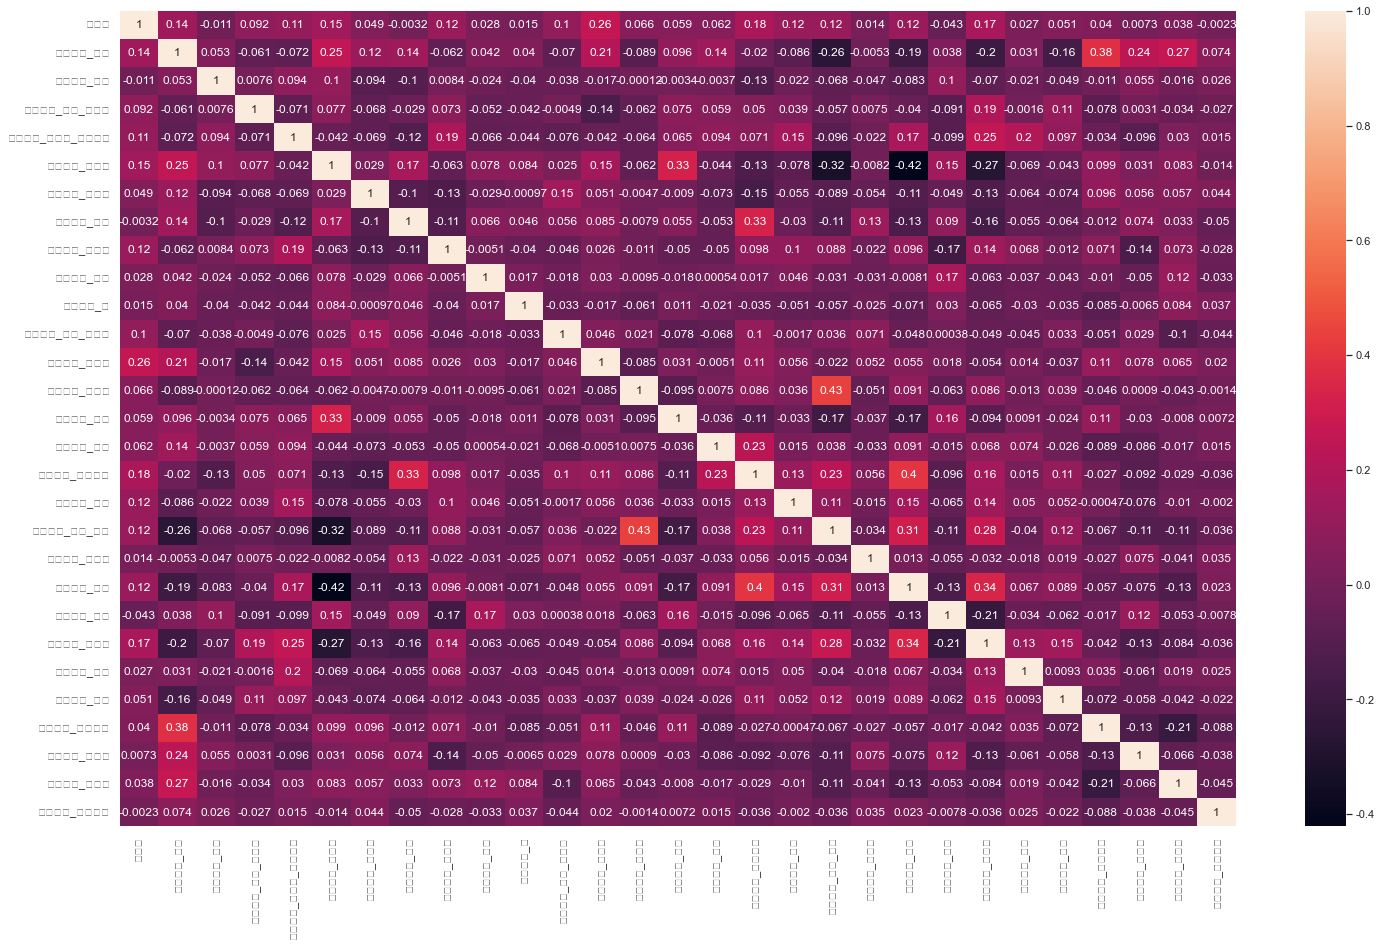

In [71]:
# plt.rcParams['font.family']= 'Malgun Gothic'

plt.rc('font', family='Malgun Gothic')

sns.set(rc={'figure.figsize':(25, 15)}) # 결과 plot 크기 키워줌

col_list=[col for col in train_test.columns if ('석식' in col)]


sns.heatmap(train_test[col_list].corr(), annot=True)

## object -> int

In [72]:
train_test['요일'].value_counts()

목    254
금    251
월    250
화    250
수    250
Name: 요일, dtype: int64

In [73]:
# 요일 -> int
train_test['요일']=train_test['요일'].replace(['월', '화', '수', '목', '금'], [4,3,2,1,0])

# EDA

### 석식메뉴 자기계발의 날

<pre>
<font color='red' size=4><b> 이거 EDA 왜 이렇게 했지? -> 이렇게 하면 0인 날만 안 걸러진다
    train_test[train_test['석식메뉴']].str.len()<=20]['석식메뉴'] 이렇게 해도 됨
    다 같은 문구로 통일시킨 후에 (ex. 자기계발)
    train_test['자기계발의날']=np.where(train_test['석식메뉴']=='자기계발', 1, 0)으로 변수 만들 수 있다.

In [74]:
train['석식메뉴'].value_counts()

    *                                                                    19
                                                                          4
    자기계발의날                                                                3
    자기개발의날                                                                3
쌀밥/잡곡밥 (쌀:국내산) 감자국  닭데리야끼조림  매운어묵볶음  참나물땅콩가루무침  포기김치 (김치:국내산)             2
                                                                         ..
닭갈비볶음밥 (쌀:국내산) 가쯔오장국  크림카레우동  감자만두/샐러드 *흑임자드레싱 비트무생채  포기김치 (김치:국내산)       1
쌀밥/잡곡밥 (쌀:국내산) 콩나물김치국  가자미튀김  모듬소세지구이  가지나물  열무김치 (김치:국내산)                1
쌀밥/잡곡밥 (쌀:국내산) 옛날돈까스  브로컬리크림스프  키위드레싱샐러드  고구마범벅/무피클 음료 포기김치 (김치:국내산)      1
쌀밥/잡곡밥 (쌀:국내산) 부대찌개  해물청경채볶음  메밀전  청포묵무침  포기김치 (김치:국내산)                   1
(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기                                 1
Name: 석식메뉴, Length: 1168, dtype: int64

In [75]:
train[train['석식메뉴']==train['석식메뉴'].value_counts().index[0]].head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식메뉴_나물_무침류,석식메뉴_피클,석식메뉴_샐러드,석식메뉴_우유,석식메뉴_빵류,석식메뉴_음료,석식메뉴_돼지고기,석식메뉴_소고기,석식메뉴_닭고기,석식메뉴_오리고기
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,...,0,0,0,0,0,0,0,0,0,0


In [76]:
train[train['석식메뉴']==train['석식메뉴'].value_counts().index[1]].head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식메뉴_나물_무침류,석식메뉴_피클,석식메뉴_샐러드,석식메뉴_우유,석식메뉴_빵류,석식메뉴_음료,석식메뉴_돼지고기,석식메뉴_소고기,석식메뉴_닭고기,석식메뉴_오리고기
549,2018-04-25,수,2714,66,285,0,0.0,모닝롤/롤케익 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 아욱된장국 감자...,비빔밥 (쌀:국내산) 유부장국 오징어튀김 떡밤초 요플레 포기김치 (김치:국내산),,...,0,0,0,0,0,0,0,0,0,0


In [77]:
train[train['석식메뉴']==train['석식메뉴'].value_counts().index[2]].head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식메뉴_나물_무침류,석식메뉴_피클,석식메뉴_샐러드,석식메뉴_우유,석식메뉴_빵류,석식메뉴_음료,석식메뉴_돼지고기,석식메뉴_소고기,석식메뉴_닭고기,석식메뉴_오리고기
667,2018-10-31,수,2805,111,306,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 느...,쌀밥/잡곡밥 (쌀:국내산) 콩나물국 수제돈가스 닭살겨자채 반달호박나물 포기김...,자기계발의날,...,0,0,0,0,0,0,0,0,0,0


In [78]:
train[train['석식메뉴']==train['석식메뉴'].value_counts().index[3]].head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식메뉴_나물_무침류,석식메뉴_피클,석식메뉴_샐러드,석식메뉴_우유,석식메뉴_빵류,석식메뉴_음료,석식메뉴_돼지고기,석식메뉴_소고기,석식메뉴_닭고기,석식메뉴_오리고기
730,2019-01-30,수,2985,66,226,1,0.0,모닝롤/소보루빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 콩나물국 치커...,"카레덮밥 (쌀:국내산,돈육:국내산) 유부장국 새우까스*칠리소스 쫄면무침 오이무...",자기개발의날,...,0,0,0,0,0,0,0,0,0,0


#### 이 날 석식 먹는 사람 수 == 0
<pre>
    *                                                                    19
                                                                          4
    자기계발의날                                                                3
    자기개발의날                                                                3
    ... 말고도 더 있다.


### 잔반없는 날처럼 요일 별로 다를지도

In [79]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '중식메뉴_육류',
       '중식메뉴_난류', '중식메뉴_죽류', '중식메뉴_덮밥_국밥류', '중식메뉴_비빔밥_볶음밥류', '중식메뉴_국탕류',
       '중식메뉴_구이류', '중식메뉴_전류', '중식메뉴_튀김류', '중식메뉴_곡물', '중식메뉴_콩류', '중식메뉴_묵',
       '중식메뉴_생선_조개류', '중식메뉴_채소류', '중식메뉴_해조류', '중식메뉴_장류', '중식메뉴_김치', '중식메뉴_만두',
       '중식메뉴_곡물가루', '중식메뉴_과일', '중식메뉴_쌀', '중식메뉴_김밥_초밥', '중식메뉴_절임류', '중식메뉴_면류',
       '중식메뉴_스튜', '중식메뉴_나물_무침류', '중식메뉴_피클', '중식메뉴_샐러드', '중식메뉴_우유', '중식메뉴_빵류',
       '중식메뉴_음료', '중식메뉴_돼지고기', '중식메뉴_소고기', '중식메뉴_닭고기', '중식메뉴_오리고기', '석식메뉴_육류',
       '석식메뉴_난류', '석식메뉴_죽류', '석식메뉴_덮밥_국밥류', '석식메뉴_비빔밥_볶음밥류', '석식메뉴_국탕류',
       '석식메뉴_구이류', '석식메뉴_전류', '석식메뉴_튀김류', '석식메뉴_곡물', '석식메뉴_콩류', '석식메뉴_묵',
       '석식메뉴_생선_조개류', '석식메뉴_채소류', '석식메뉴_해조류', '석식메뉴_장류', '석식메뉴_김치', '석식메뉴_만두',
       '석식메뉴_곡물가루', '석식메뉴_과일', '석식메뉴_쌀', '석식메뉴_김밥_초밥', '석식메뉴_절임류', '석식메뉴_면류',
       '석식메뉴_스튜', '석식메뉴_나물_무침류', '석식메뉴_피클', '석식메뉴_샐러드', '석식메뉴_우유', '석식메뉴_빵류',
       '석식메뉴_음료', '석

In [80]:
train.groupby(by='요일')['중식계'].mean().sort_values(ascending=False)

요일
월    1144.331950
화     925.620833
수     905.213389
목     823.991803
금     653.609959
Name: 중식계, dtype: float64

In [81]:
train.groupby(by='요일')['석식계'].mean().sort_values(ascending=False)

요일
월    538.933610
화    520.129167
목    480.401639
금    404.979253
수    363.615063
Name: 석식계, dtype: float64

## before 코로나, after 코로나

<AxesSubplot:xlabel='일자', ylabel='중식계'>

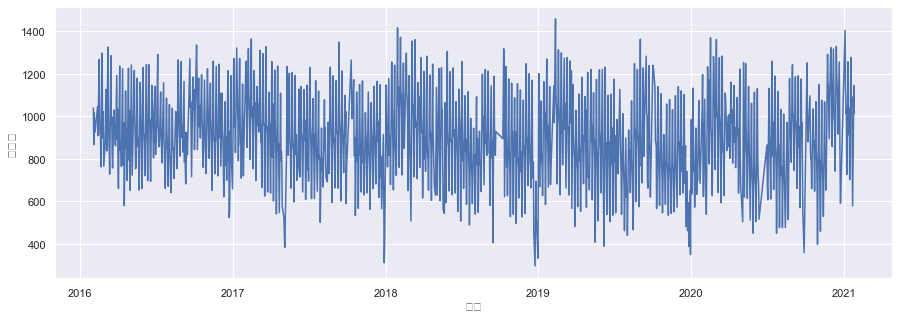

In [82]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(y=train['중식계'], x=train['일자'])

<AxesSubplot:xlabel='일자', ylabel='석식계'>

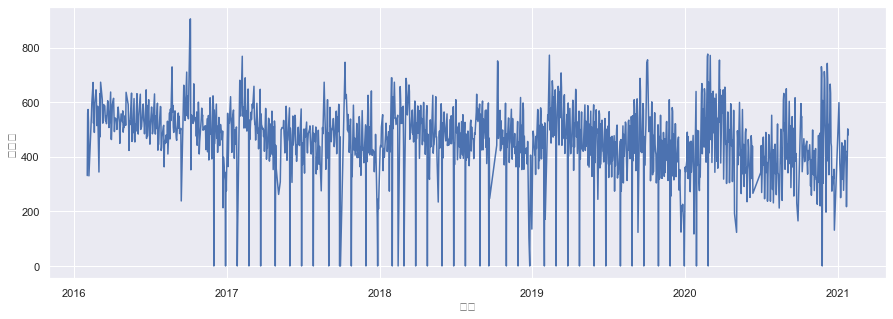

In [83]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(y=train['석식계'], x=train['일자'])

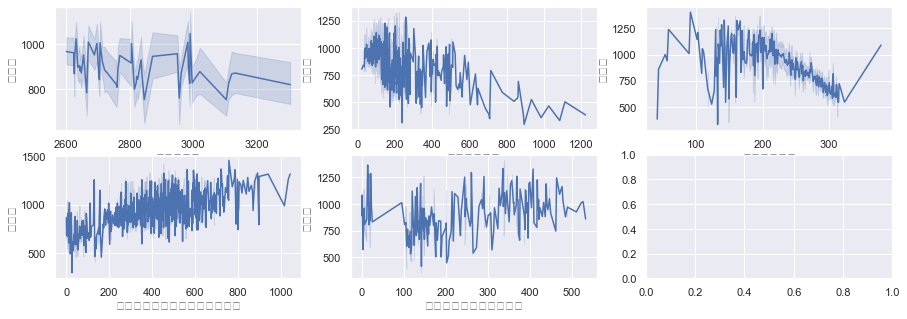

In [84]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

sns.set(rc={'figure.figsize':(15, 5)})

col_list=train.columns[2:7]
f, axs=plt.subplots(2,3)

for a, col in enumerate(col_list):
    i=a//3
    j=a%3
    sns.lineplot(x=train[col], y=train['중식계'], ax=axs[i,j])
    
#             본사정원수	본사휴가자수	본사출장자수

# 본사시간외근무명령서승인건수	현본사소속재택근무자수	

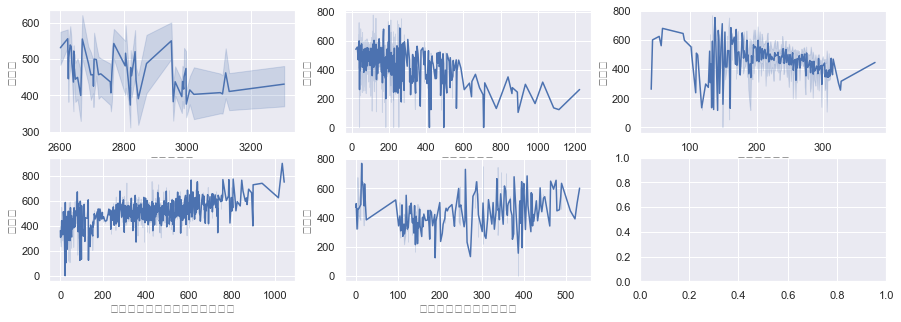

In [85]:
# from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

sns.set(rc={'figure.figsize':(15, 5)})

col_list=train.columns[2:7]
f, axs=plt.subplots(2,3)

for a, col in enumerate(col_list):
    i=a//3
    j=a%3
    sns.lineplot(x=train[col], y=train['석식계'], ax=axs[i,j])
    
# 본사정원수	본사휴가자수	본사출장자수

# 본사시간외근무명령서승인건수	현본사소속재택근무자수	

# 일단 제출

In [86]:
train_test=train_test.set_index('일자')

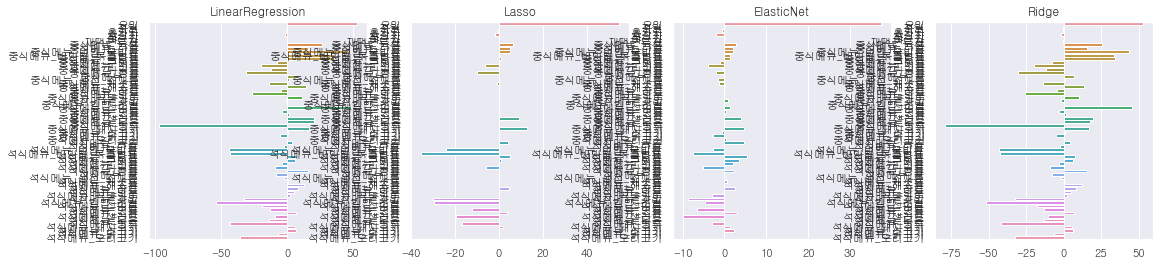

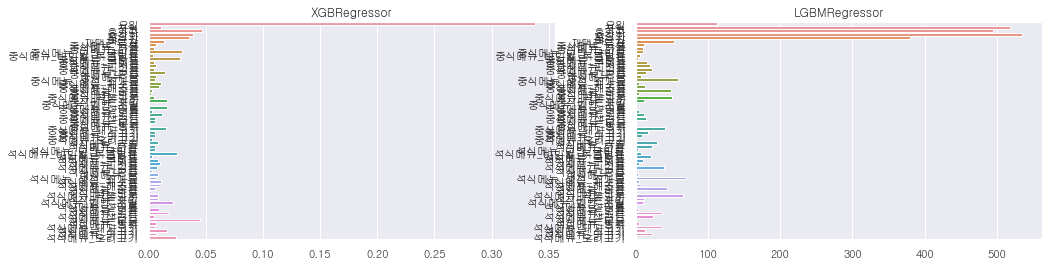

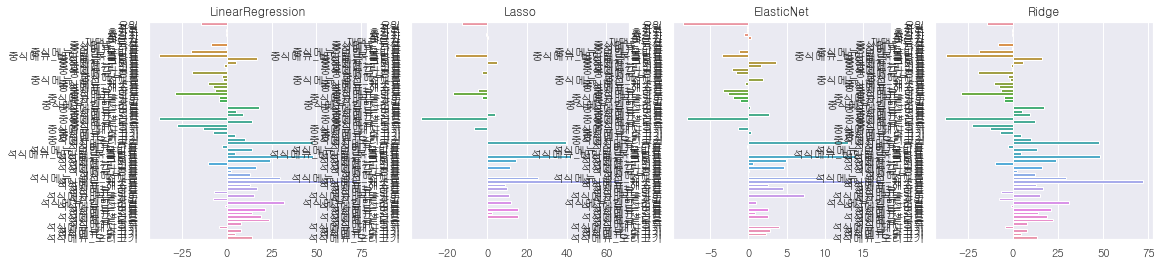

,첫시도_중,첫시도_석
LinearRegression(),86.711160,66.056966
Lasso(),83.978850,64.605482
ElasticNet(),86.140167,66.819855
Ridge(),86.362009,65.947302
XGBRegressor(),71.919987,51.964495
LGBMRegressor(),71.333376,51.007143


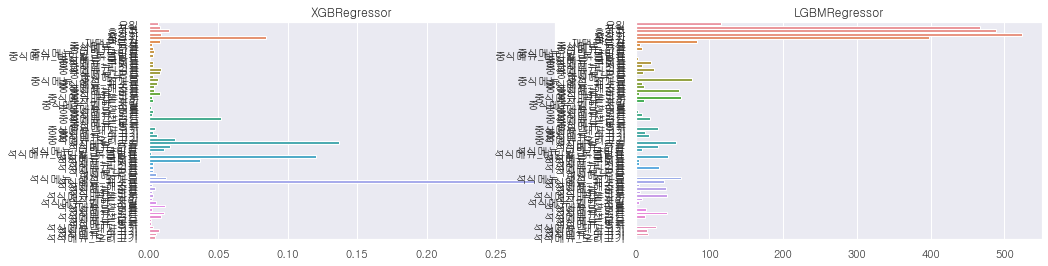

In [87]:
fit_score(data=train_test, target='중식계', model_list=False, trial_name='첫시도_중', DF=True)
fit_score(data=train_test, target='석식계', model_list=False, trial_name='첫시도_석', DF=True)
sco_df

## train_test

# 2차종합가공

## 석식계 0인 날 -> drop (모델 성능에 영향 줄까봐)

In [88]:
train_test=train_test[train_test['석식계']!=0]

In [89]:
train.groupby(by='요일')['중식계'].mean().sort_values(ascending=False)

요일
월    1144.331950
화     925.620833
수     905.213389
목     823.991803
금     653.609959
Name: 중식계, dtype: float64

In [90]:
train.groupby(by='요일')['석식계'].mean().sort_values(ascending=False)

요일
월    538.933610
화    520.129167
목    480.401639
금    404.979253
수    363.615063
Name: 석식계, dtype: float64

## 재택근무자 100명 미만

### 0으로 두기 -> 중식계, lgb는 성능 내려감 대신 gb가 lgb보다 좋아짐, 석식계, 성능 오름

In [92]:
# 재택근무자 100명 미만 0으로 두면??? or drop하면??
# 데이터 너무 적어짐
train_test['재택근무자']=train_test['재택근무자'].apply(lambda x : 0 if (x<=100) else x)

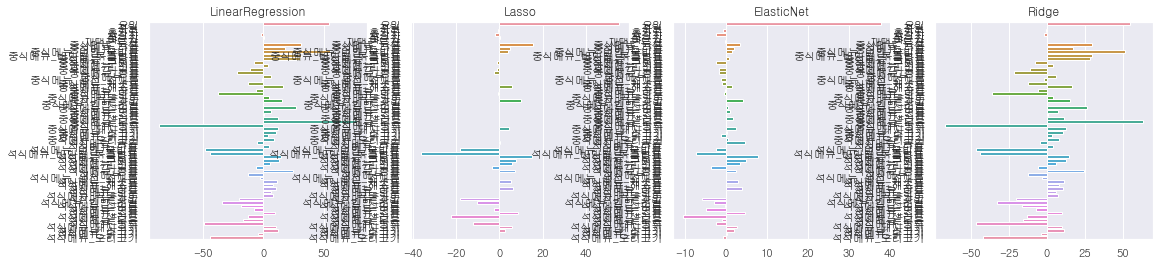

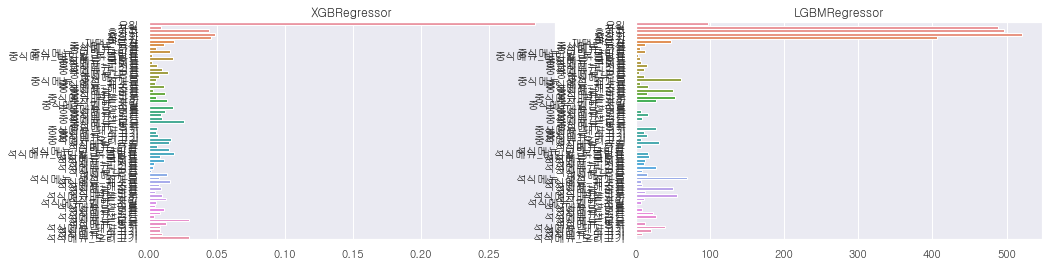

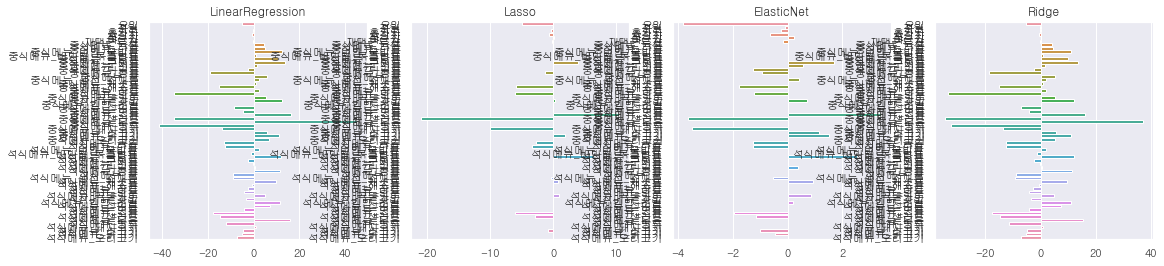

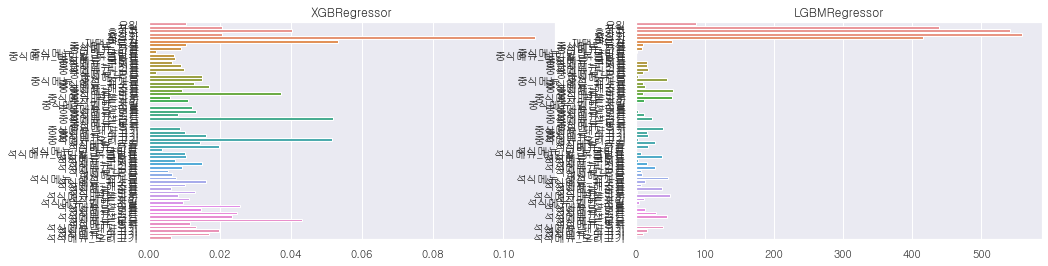

In [93]:
fit_score(data=train_test, target='중식계', model_list=False, trial_name='재택100미만0_중', DF=True)
fit_score(data=train_test, target='석식계', model_list=False, trial_name='재택100미만0_석', DF=True)

## 본사 휴가자 비율

In [94]:
train_test['정원_휴가_비율']=(train_test['휴가자']/train_test['정원'])*100

<AxesSubplot:xlabel='일자'>

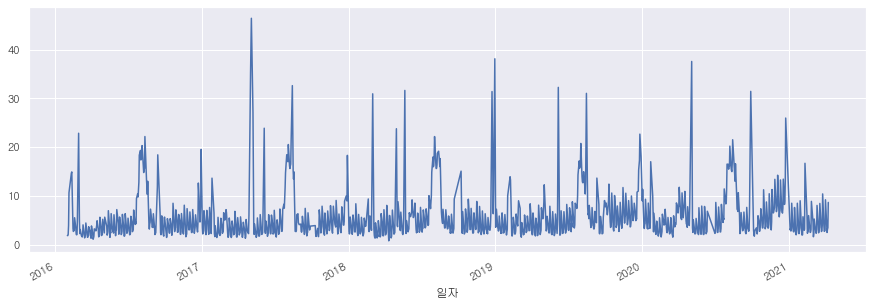

In [95]:
train_test['정원_휴가_비율'].plot()

### 본사휴가자비율 열 추가 후 train_test2로 시도

In [96]:
train_test2=train_test.copy()

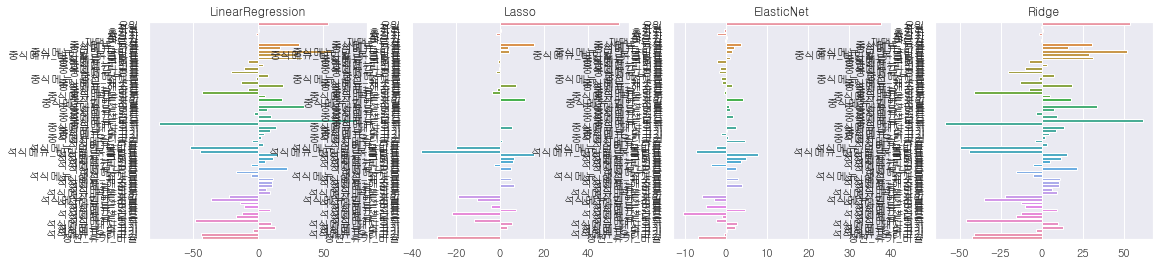

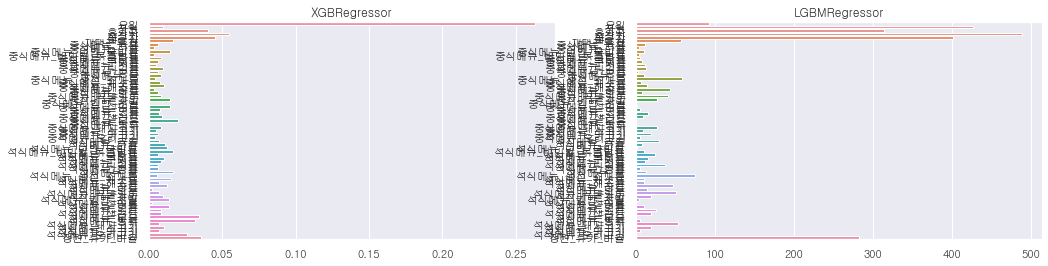

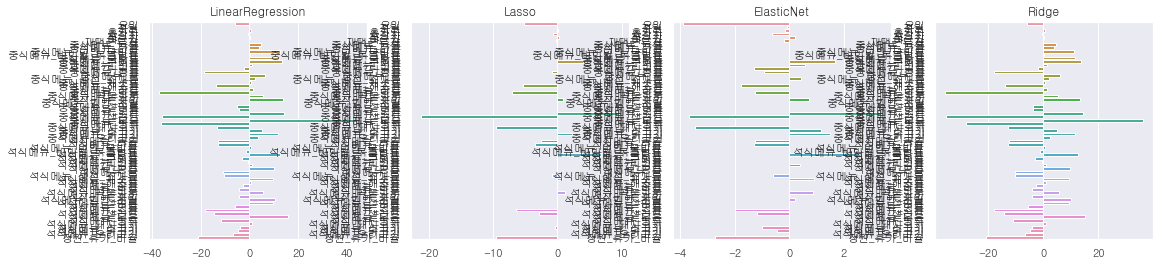

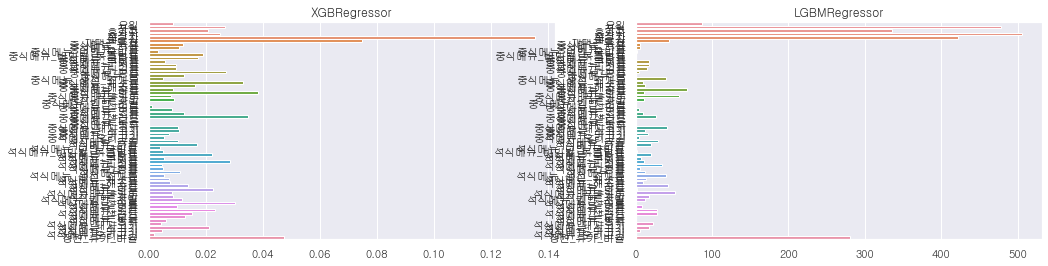

In [97]:
fit_score(data=train_test2, target='중식계', model_list=False, trial_name='본사휴가자비율_중', DF=True)
fit_score(data=train_test2, target='석식계', model_list=False, trial_name='본사휴가자비율_석', DF=True)

#### -> 낮은 것도 차이 나서 구간화 안 하고 그냥 피쳐 특성 살려두기로..

### log 변환

In [98]:
train_test['정원_휴가_비율']=np.log1p(train_test['정원_휴가_비율'])

In [99]:
# fit_score(data=train_test2, target='중식계', model_list=False, trial_name='정원_휴가_비율_log_석', DF=False)
# fit_score(data=train_test2, target='석식계', model_list=False, trial_name='정원_휴가_비율_log_석', DF=False)

In [100]:
sco_df

,첫시도_중,첫시도_석,재택100미만0_중,재택100미만0_석,본사휴가자비율_중,본사휴가자비율_석
LinearRegression(),86.711160,66.056966,87.127471,58.580281,86.127388,58.042877
Lasso(),83.978850,64.605482,84.151575,55.770076,83.395593,55.523821
ElasticNet(),86.140167,66.819855,86.760152,56.242063,86.550692,56.184130
Ridge(),86.362009,65.947302,86.728264,58.473829,85.757802,57.955085
XGBRegressor(),71.919987,51.964495,71.203105,49.511985,70.933442,50.359665
LGBMRegressor(),71.333376,51.007143,72.062473,48.779326,72.181521,49.721210


#### lgbm은 거의 효과 없다. 나머지는 약간 좋아짐

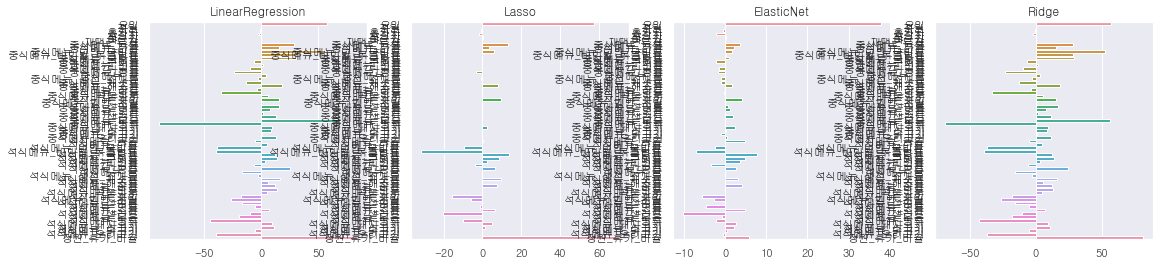

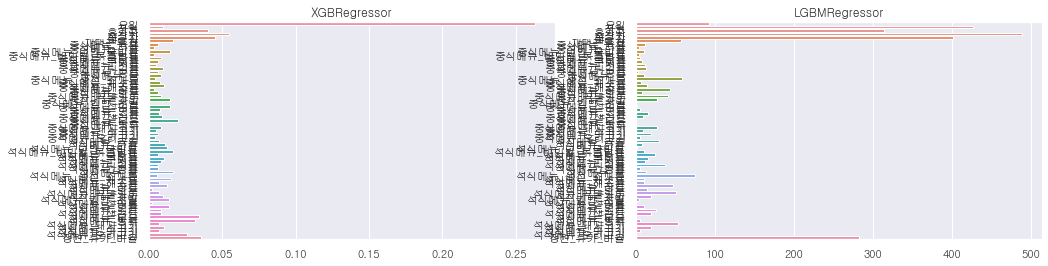

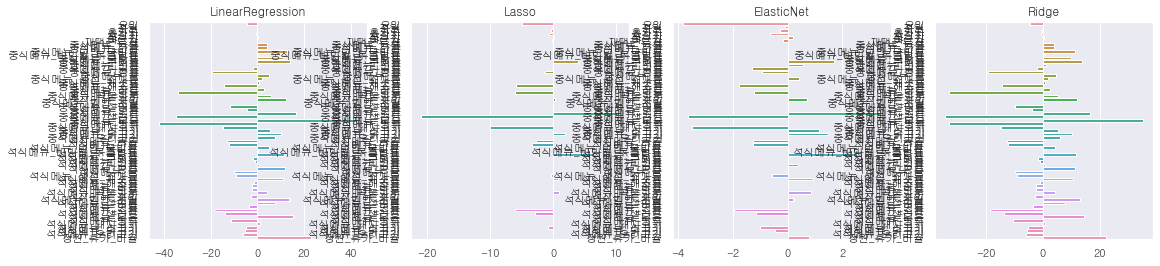

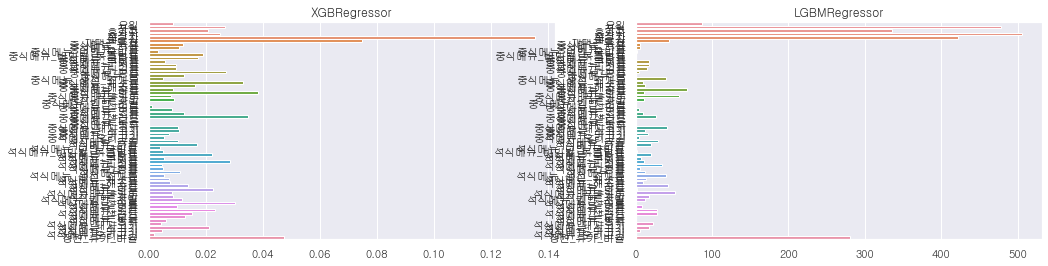

In [101]:
sco_df.drop(['본사휴가자비율_중',	'본사휴가자비율_석'], axis=1)
fit_score(data=train_test, target='중식계', model_list=False, trial_name='정원_휴가_비율_log_석', DF=True)
fit_score(data=train_test, target='석식계', model_list=False, trial_name='정원_휴가_비율_log_석', DF=True)

둘 다 : 석식계 0 drop, 코로나 변수(코로나 전후로 비율 달라져서), 출근자 변수, 공휴일 변수

중식 : 야근자 drop, 코로나 , 메뉴조정(육류), 석식메뉴 drop,

석식 : 메뉴 drop(또는 메뉴조정 (육류)) , 중식메뉴 drop, 코로나 0,1이나
    
* 정원/ 휴가 비율 급격히 증가한 건 공휴일 변수로 처리()
* 출근자 수 변수 -> 코로나 전 후로 중식, 석식 먹는 비중 증가

* 출근자랑 공휴일 변수 만들면 석식에서 야근자 빼고 나머지 인원 변수 drop해도 될듯 이건 결과 봐서


## 중식 석식

In [102]:
train_test_중식=train_test.copy()
train_test_석식=train_test.copy()

### 중식

중식 : 야근자 drop, 코로나 , 메뉴조정(육류), 석식메뉴 drop,

* 출근자랑 공휴일 변수 만들면 석식에서 야근자 빼고 나머지 인원 변수 drop해도 될듯 이건 결과 봐서


#### 야근자 drop

In [103]:
train_test_중식=train_test_중식.drop('야근자', axis=1)

#### 석식 메뉴 drop

In [104]:
suc_col=[col for col in train_test_중식.columns if ('석식메뉴' in col)]
train_test_중식=train_test_중식.drop(suc_col, axis=1)

## 석식

둘 다 : 석식계 0 drop, 코로나 변수(코로나 전후로 비율 달라져서), 출근자 변수, 공휴일 변수

석식 : 메뉴 drop(또는 메뉴조정 (육류)) , 중식메뉴 drop
    
* 정원/ 휴가 비율 급격히 증가한 건 공휴일 변수로 처리()
* 출근자 수 변수 -> 코로나 전 후로 중식, 석식 먹는 비중 증가

* 출근자랑 공휴일 변수 만들면 석식에서 야근자 빼고 나머지 인원 변수 drop해도 될듯 이건 결과 봐서


#### 메뉴 조정

#### 중식 메뉴 drop

In [105]:
suc_col=[col for col in train_test_석식.columns if ('중식메뉴' in col)]
train_test_석식=train_test_석식.drop(suc_col, axis=1)

## 점수 보기

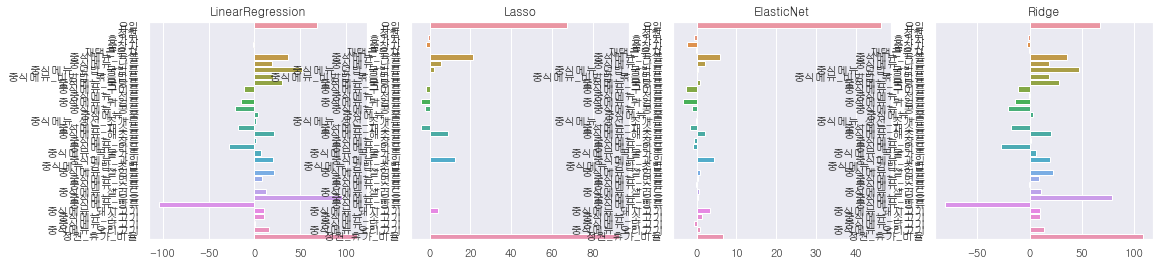

LinearRegression()    89.236933
Lasso()               87.642209
ElasticNet()          90.366322
Ridge()               88.926374
XGBRegressor()        76.215267
LGBMRegressor()       75.198213
Name: 중식, dtype: float64


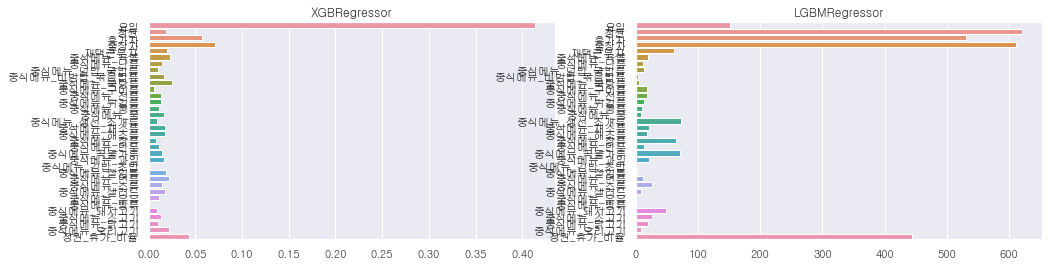

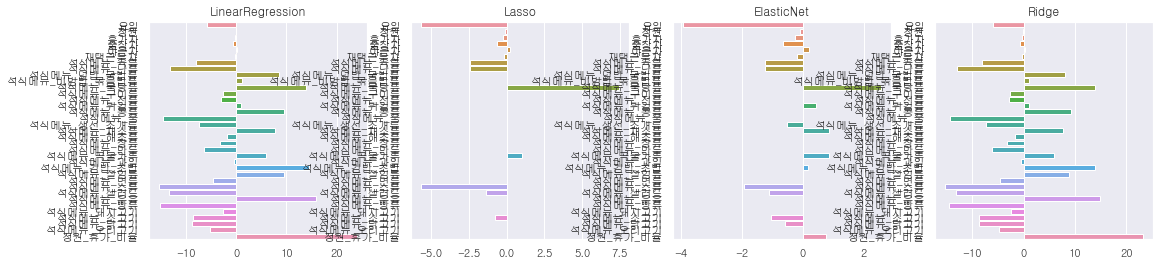

LinearRegression()    57.079839
Lasso()               56.364357
ElasticNet()          56.454406
Ridge()               57.056706
XGBRegressor()        49.087989
LGBMRegressor()       47.341410
Name: 석식, dtype: float64


,첫시도_중,첫시도_석,재택100미만0_중,재택100미만0_석,본사휴가자비율_중,본사휴가자비율_석,정원_휴가_비율_log_석,정원_휴가_비율_log_석
LinearRegression(),86.711160,66.056966,87.127471,58.580281,86.127388,58.042877,87.570143,57.796668
Lasso(),83.978850,64.605482,84.151575,55.770076,83.395593,55.523821,84.541659,55.770092
ElasticNet(),86.140167,66.819855,86.760152,56.242063,86.550692,56.184130,86.698198,56.211959
Ridge(),86.362009,65.947302,86.728264,58.473829,85.757802,57.955085,87.155571,57.730831
XGBRegressor(),71.919987,51.964495,71.203105,49.511985,70.933442,50.359665,70.940054,50.359665
LGBMRegressor(),71.333376,51.007143,72.062473,48.779326,72.181521,49.721210,72.181521,49.721210


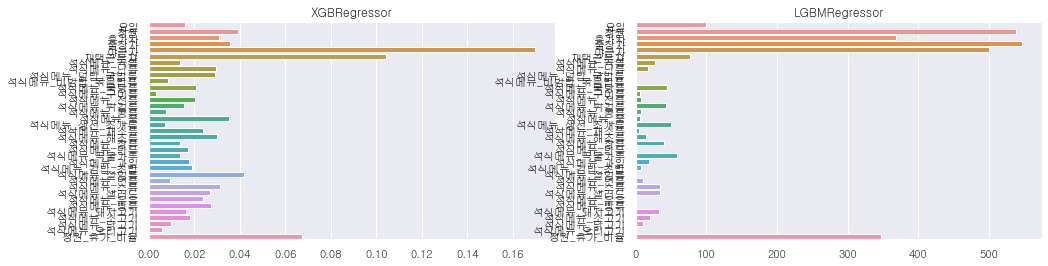

In [106]:
fit_score(data=train_test_중식, target='중식계', model_list=False, trial_name='중식', DF=False)
fit_score(data=train_test_석식, target='석식계', model_list=False, trial_name='석식', DF=False)
sco_df

# 제출

### 중식

In [111]:
train, test=my_split(train_test_중식)
model_list=[LinearRegression(),Lasso(),ElasticNet(),Ridge(), XGBRegressor(),LGBMRegressor()]

#----------------------------------------------- 하단 코드 동일
y = train['중식계']
X = train.drop(['중식계','석식계'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
model= LGBMRegressor()
for model in model_list:
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    print(f" MAE:{mae:.4f} {model.__class__.__name__}") 


#------------------------------------------------- 공모전 제출용 학습
test_pred = model.predict(test)        #---------->  submit 제출 답안
test_pred = np.round(test_pred, 0).astype(int)

#------------------------------------------------- 제출 전 확인
print(len(test_pred), test_pred)
print(sub['중식계'].min(), sub['중식계'].max())
print(test.index.values.min()   , test.index.values.max())
sub.head(1)
#------------------------------------------------- 답안지 작성
sub['중식계'] = test_pred.reshape(-1,1)
print(sub.head(2))
sub.to_csv("v05.csv", index=False)   

 MAE:84.2843 LinearRegression
 MAE:83.3514 Lasso
 MAE:86.1192 ElasticNet
 MAE:84.2720 Ridge
 MAE:69.1178 XGBRegressor
 MAE:73.9471 LGBMRegressor
50 [1079  924  533 1209  994  898  909  619 1239 1001  835 1173 1004 1035
  829  621 1158  970  906  783  573 1028  976  861  609 1181 1029 1085
  867  686 1164  995  951  877  606 1213  937  813  772  543 1236  980
  904  802  561 1168 1020  853  801  599]
533 1239
2021-01-27T00:00:00.000000000 2021-04-09T00:00:00.000000000
           일자   중식계  석식계
0  2021-01-27  1079  383
1  2021-01-28   924  417


In [ ]:
train, test=my_split(train_test_석식)
model_list=[LinearRegression(),Lasso(),ElasticNet(),Ridge(), XGBRegressor(),LGBMRegressor()]

#----------------------------------------------- 하단 코드 동일
y = train['석식계']
X = train.drop(['중식계','석식계'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=1234)
model= LGBMRegressor()
for model in model_list:
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    print(f" MAE:{mae:.4f} {model.__class__.__name__}") 


#------------------------------------------------- 공모전 제출용 학습
test_pred = model.predict(test)        #---------->  submit 제출 답안
test_pred = np.round(test_pred, 0).astype(int)

#------------------------------------------------- 제출 전 확인
print(len(test_pred), test_pred)
print(sub['석식계'].min(), sub['석식계'].max())
print(test.index.values.min()   , test.index.values.max())
sub.head(1)
#------------------------------------------------- 답안지 작성
sub['석식계'] = test_pred.reshape(-1,1)
print(sub.head(2))
sub.to_csv("v05.csv", index=False)   

 MAE:56.9591 LinearRegression
 MAE:55.5787 Lasso
 MAE:55.6371 ElasticNet
 MAE:56.9226 Ridge
 MAE:50.1212 XGBRegressor
 MAE:50.3758 LGBMRegressor
50 [383 417 248 511 394 422 426 362 586 444 220 724 605 398 440 385 644 596
 345 435 239 634 451 478 368 626 597 378 470 269 654 478 396 432 267 583
 500 363 389 258 571 455 391 396 252 561 480 395 415 253]
220 724
2021-01-27T00:00:00.000000000 2021-04-09T00:00:00.000000000
           일자   중식계  석식계
0  2021-01-27  1079  383
1  2021-01-28   924  417


# 모델 고도화

## 중식계 -> XGB

In [ ]:
# train_test_중식

### grid

In [122]:
# train, test = my_split(train_test_중식)

# y = train['중식계']
# X = train.drop(['중식계', '석식계'], axis=1)
# X_train,X_val, y_train, y_val = train_test_split(X, y, random_state=1024, shuffle=True)

# model = XGBRegressor(random_state=1024)
# #-- 튜닝 : 하이퍼파라미터 값을 임의로 변경해서 모델의 성능을 좋게 한다.
# myparam = {'learning_rate': [0.05, 0.1, 0.2],
#            'reg_lambda': [ 0.7, 0.8, 1],
#            'n_estimators' : [30, 50, 70]
#         }

# kfold = KFold(n_splits=10, shuffle=True, random_state=1024) 
# gcv_model = GridSearchCV(model, param_grid=myparam, scoring='neg_mean_absolute_error', refit=True, cv=kfold)


# gcv_model.fit(X_train, y_train)
# print(gcv_model.best_score_)
# print(gcv_model.best_params_)
# # print(gcv_model.cv_results_)



-75.17967773923804
{'learning_rate': 0.1, 'n_estimators': 50, 'reg_lambda': 1}


In [121]:
# pred=gcv_model.predict(test)

In [119]:
# sub['중식계']=pred.reshape(-1,1)
# # sub.to_csv(f'./v_gcv.csv', index=False)

NameError: name 'submit' is not defined

### Stacking

In [126]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import VotingRegressor

# train, test = my_split(train_test_중식)

# y = train['중식계']
# X = train.drop(['중식계', '석식계'], axis=1)
# X_train,X_val, y_train, y_val = train_test_split(X, y, random_state=1024, shuffle=True)


# model1 = [('xg', XGBRegressor()),
#           ('lr', LGBMRegressor()),
#           ('gcv', gcv_model)
#          ]
# model2 = XGBRegressor(random_state=1024)        

# stacking_model = StackingRegressor(estimators    = model1, 
#                            final_estimator= model2, 
#                            cv=5)
# stacking_model.fit(X_train, y_train)   
# pred = stacking_model.predict(X_val)
# rmsle = mean_absolute_error(y_val, pred)
# print(rmsle)

TypeError: mean_absolute_error() got an unexpected keyword argument 'squared'

In [137]:
# pred = stacking_model.predict(test)
# pred=np.expm1(pred)
# submit['count']=pred.reshape(-1,1)
# submit.to_csv(f'./dataset/v11_stacking.csv', index=False)

In [146]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import VotingRegressor

# X_train, X_val, y_train, y_val=my_train_val_split(X,y,cutoff_day=15)


# model1 = [('lrg', LGBMRegressor()),
#           ('rf', RandomForestRegressor(),
#           ('add',AdaBoostRegressor()))
#          ]
# model2 = LGBMRegressor(random_state=1024)        

# stacking_model = StackingRegressor(estimators    = model1, 
#                            final_estimator= model2, 
#                            cv=5)
# stacking_model.fit(X_train, y_train)   
# pred = stacking_model.predict(X_val)
# rmsle = mean_squared_log_error(y_val, pred, squared=False)
# print(rmsle)

0.08547277392350482


In [147]:
# pred = stacking_model.predict(test)
# pred=np.expm1(pred)
# submit['count']=pred.reshape(-1,1)
# submit.to_csv(f'./dataset/v11_stacking2.csv', index=False)

## 석식계-> LGBMRegressor

In [ ]:
# train_test_석식